In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

import time
from approxeng.input.selectbinder import ControllerResource
from IPython.display import display, clear_output
from jetcam.utils import bgr8_to_jpeg
from matplotlib import pyplot as plt
import numpy as np
import cv2
import ipywidgets
import serial

In [2]:
from camera import Camera
from CV_FIND import CV_IMG_PROCESSOR
# Nvidia Model
width = int(244)
height = int(244)

camera = Camera(width=width, height=height, capture_width=1280, capture_height=720, capture_fps=60, capture_flip=2)
main_cv = CV_IMG_PROCESSOR()

In [ ]:
# reset cam
camera.unobserve_all()
camera.stop()

In [3]:
# Source: https://towardsdatascience.com/deeppicar-part-5-lane-following-via-deep-learning-d93acdce6110
# Convolution Layers
from keras import layers, models, optimizers, regularizers

frame = layers.Input(shape=(66, 200, 3), name='input')

c1 = layers.Convolution2D(filters=24, kernel_size=5, strides=2, activation='elu')(frame)
c2 = layers.Convolution2D(filters=36, kernel_size=5, strides=2, activation='elu')(c1)
c3 = layers.Convolution2D(filters=48, kernel_size=5, strides=2, activation='elu')(c2)
c4 = layers.Convolution2D(filters=64, kernel_size=3, activation='elu')(c3)
c5 = layers.Convolution2D(filters=64, kernel_size=3, activation='elu')(c4)

l1 = layers.Flatten()(c5)
l2 = layers.Dense(100, activation='elu')(l1)
l3 = layers.Dense(50, activation='elu')(l2)
l4 = layers.Dense(10, activation='elu')(l3)

output = layers.Dense(1)(l4)

model = models.Model(inputs=[frame], outputs=output) 

# we use MSE (Mean Squared Error) as loss function
optimizer = optimizers.Adam(lr=1e-3) # learning rate
model.compile(loss='mse', optimizer=optimizer)
    
print(model.summary())

Using TensorFlow backend.
/home/vikram/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/vikram/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/vikram/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/vikram/.local/lib/python3.6/site-packages/tensorflow/python

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_____________________________________________________

In [4]:
from IPython.display import display, clear_output
from collections import namedtuple, deque
import serial
import random as rn

SHOW_LIVE = True
BENCHMARK = True
Frames = []
all_times = []
ID = 0
experience = namedtuple("Data", field_names=["image", "action"])
widget_train = ipywidgets.Image(format='jpeg', width=width, height=height/2)

def update_images(): 

    #img = change['new']
    img = camera.value
    main_cv.getSteering(img,"canny")
    img2 = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2YUV)
    img2 = cv2.resize(img2, (200,66))
    img2 = np.expand_dims(img2, axis=0) / 255
    main_cv.preprocessed_img = img2
    main_cv.raw_img = img
    #main_cv.flag = True

SHAPE: (1, 66, 200, 3)


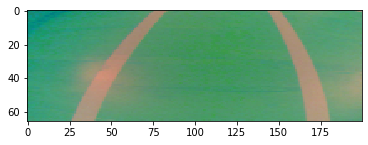

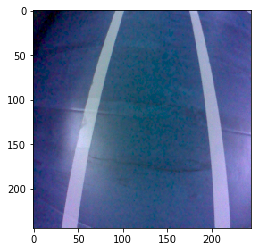

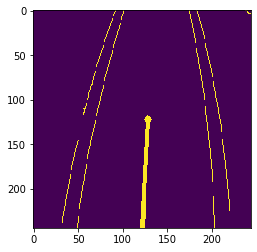

In [5]:
update_images()
print("SHAPE:", (main_cv.preprocessed_img).shape)
plt.imshow(np.squeeze(main_cv.preprocessed_img))
plt.show()
plt.imshow(main_cv.raw_img)
plt.show()
plt.imshow(main_cv.preview_img)
plt.show()

In [36]:
import time
from approxeng.input.selectbinder import ControllerResource
from sklearn.metrics import mean_squared_error, r2_score

if(SHOW_LIVE):
    display(widget_train)
    
times = []
turn_buffer = []
regular_buffer = []
validate_memory = []

# DashCAM only supports 1280x720 @ 30 fps
# PI Cam 160 FOV 60 FPS @ 1280x720
# Tested ~ 67 FPS
with serial.Serial('/dev/ttyUSB0', 1000000, timeout=1) as ser:
    with ControllerResource() as joystick:
        CONST_TIME = 0.017
        P = 4
        D = 0.03
        error_old = 0
        
        TRAIN = False
        AUTO_THROTTLE = False
        STEERING = 90
        THROTTLE = 90
        DEBUG = 0
        count = 1
        loss = 0
        loop_start = time.time()
        speed = 0
        state = main_cv.preprocessed_img
        
        while joystick.connected:
            
            if(BENCHMARK):
                start_time = time.time()
                
            if(joystick['cross'] is not None):  # SQUARE EXIT
                print("EXIT")
                ser.close()
                break
            if(joystick['triangle'] is not None):  # TRIANGLE TOGGLE TRAIN
                if(TRAIN):
                    print("TRAIN STOP")
                    all_times.append((time.time()-loop_start))
                    TRAIN = False
                else:
                    print("TRAIN START")
                    TRAIN = True
                    loop_start = time.time()
                time.sleep(0.2)
                
            update_images()
                
            # PD
            error = (main_cv.angle-90) # -90 0 90
            P_T = error * P
            D_T = ((error-error_old)/CONST_TIME)*D
            cv_action = int(np.clip(((P_T-D_T)+90), 2, 178))
            #cv_action = int(cv_action/5)*5
            error_old = error
            
            predict_value = model.predict(main_cv.preprocessed_img) # 
            STEERING = int(max(predict_value,0))
            
            if(TRAIN):
                STEERING = cv_action
                d = experience(main_cv.preprocessed_img, STEERING)
                if(STEERING < 30 or STEERING > 160):
                    THROTTLE = 150
                    
                # Reduced FPS during training
                if(count % 30 == 0):
                    if(DEBUG == 0 and (len(turn_buffer) > 5 and len(regular_buffer) > 5)):
                        chance = rn.randint(0, 1)
                        if(chance==0):
                            rnd_idx = rn.randint(0, len(turn_buffer)-1)
                            loss = (model.fit(turn_buffer[rnd_idx][0], np.array([turn_buffer[rnd_idx][1]]), epochs=1, verbose=0)).history['loss'][0]
                        else:
                            rnd_idx = rn.randint(0, len(regular_buffer)-1)
                            loss = (model.fit(regular_buffer[rnd_idx][0], np.array([regular_buffer[rnd_idx][1]]), epochs=1, verbose=0)).history['loss'][0]
                        
                        #loss = (model.fit(main_cv.preprocessed_img, np.array([STEERING]), epochs=1, verbose=0)).history['loss'][0]
                        ID += 1
                        
               
                if(count % 10 == 0):
                    state = main_cv.preprocessed_img
                    if(len(turn_buffer) > 150):
                        turn_buffer.clear()
                    if(len(regular_buffer) > 150):
                        regular_buffer.clear()
                        
                    # Only left at the moment
                    if(STEERING  > 110 or STEERING < 60):
                        turn_buffer.append(d)
                    else:
                        regular_buffer.append(d)

                if(count % 60 == 0):
                    if(len(validate_memory) == 200):
                        #validate_memory.popleft()
                        validate_memory.clear()
                    validate_memory.append(d)
                    
                count += 1
                
            if(joystick['square'] is not None):# LB for auto-throttle
                if(AUTO_THROTTLE):
                    AUTO_THROTTLE = False
                else:
                    AUTO_THROTTLE = True
                time.sleep(0.2)
                
            if(AUTO_THROTTLE):
                THROTTLE = int(-70) # RPM
            else:
                THROTTLE = int((joystick['ly']+1)/2*180)

            # Manual 
            if(joystick['l1'] is not None):# L trigger for manual
                STEERING = int((joystick['rx']+1)/2*180)
                THROTTLE = int((joystick['ly']+1)/2*180)

            # Compute Validate Score
            if(joystick['circle'] is not None): # (X)
                print("TRAIN STOP")
                all_times.append((time.time()-loop_start))
                TRAIN = False
                AUTO_THROTTLE = False
                
                # Stop Car
                output = "{:05d}-{:05d}\n".format(int(90), int(STEERING))
                ser.write(bytes(output,'utf-8'))
                ser.write(bytes(output,'utf-8'))
                time.sleep(0.2)
                
                Y_true = []
                Y_pred = []
                if(len(validate_memory) >= 30):
                    print("Train:", len(validate_memory))
                    for i in range(max(len(validate_memory),100)):
                        rnd_idx = rn.randint(0, len(validate_memory)-1)
                        Y_pred.append(int(model.predict(validate_memory[rnd_idx][0])))
                        Y_true.append(validate_memory[rnd_idx][1])
                        
                    MSE = ((np.array(Y_pred) - np.array(Y_true)) ** 2).mean()     
                    print(MSE)
                    
                    mse = mean_squared_error(Y_true, Y_pred)
                    r_squared = r2_score(Y_true, Y_pred)
                    print("mse    {:1.3f} ".format(mse))
                    print("r_squared    {:1.3f} ".format(r_squared))
                else:
                    print("Not enough samples")
                    time.sleep(0.2)
                
            if(SHOW_LIVE):
                output = "{:05d}-{:05d}\n".format(int(THROTTLE), int(STEERING))
                ser.write(bytes(output,'utf-8'))
                #time.sleep(0.001)
                speed_in = (ser.readline())
                if speed_in:
                    speed = speed_in
                    
                info_str = "SPEED {:1d} Predict {:1d} STEER {:1d}".format(int(speed), int(predict_value), cv_action)
                second_line = "V_MEM {:1d} ID {:1d} loss {:1.3f}".format(len(validate_memory), ID, loss)
                third_line = "T_BUFF {:1d} R_BUFF {:1d}".format(len(turn_buffer), len(regular_buffer))

                if(TRAIN):
                    preview = np.squeeze((state).copy())*255
                else:
                    preview = main_cv.preview_img
                    
                cv2.putText(preview, info_str, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0))
                cv2.putText(preview, second_line, (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0))
                cv2.putText(preview, third_line, (0, 45), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0))
                
                cv2.circle(preview, (int(main_cv.line[0]), int(122)), 4, (255,0,0),  -1)
                widget_train.value = bgr8_to_jpeg(preview)

            if(BENCHMARK):
                delta = (time.time() - start_time)
                times.append(delta)
            
if(BENCHMARK):
    mean_delta = np.array(times).mean()
    fps = 1 / mean_delta
    total_time = sum(all_times)
    
    print('average(sec):{:.2f}, fps:{:.2f}, run_time:{:.2f}'.format(mean_delta, fps, total_time))

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

TRAIN START
TRAIN STOP
EXIT
average(sec):0.02, fps:51.76, run_time:13366.52


In [ ]:
main_cv.arc_length_min = 170
main_cv.canny_min = 130

In [33]:
model.save("./model/sdadsa.h5")

In [ ]:
for i in validate_memory:
    widget_train.value = bgr8_to_jpeg(np.squeeze(i[0]*255))
    time.sleep(0.1)

In [37]:
camera.stop()